In [1]:
import gc
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tsforest.utils import make_time_range
from mahts import HTSDistributor

# local modules
import sys
sys.path.append("../lib/")
from utils import (compute_scaling, compute_weights, reduce_mem_usage, 
                   compute_scales_by_level, compute_weights_by_level)
from evaluation import _WRMSSEEvaluator, WRMSSEEvaluator, Evaluator, WRMSSEEvaluatorL12
from trend import TrendEstimator

***
## Data loading

In [2]:
data = (pd.read_parquet("../input/train_dataframe.parquet", 
                        columns=["ts_id","item_id", "dept_id", "cat_id", "store_id", "state_id", "q", "ds", "no_stock_days"])
        .rename({"q":"y"}, axis=1))

scaling_input = pd.read_parquet("../input/scaling_input.parquet")
weighting_input = pd.read_parquet("../input/weighting_input.parquet")

hierarchy = pd.read_parquet("../input/hierarchy.parquet")
hierarchy_raw = pd.read_parquet("../input/hierarchy_raw.parquet")

In [3]:
forecast = pd.read_csv("../output/forecast-f3.csv", parse_dates=["ds"])
valid_start = forecast.ds.min()
valid_end = forecast.ds.max()
valid_period = (pd.to_datetime(valid_start), pd.to_datetime(valid_end))

In [4]:
%%time
scales_by_level = compute_scales_by_level(scaling_input, valid_period[0])
weights_by_level = compute_weights_by_level(weighting_input, valid_period[0])

CPU times: user 1min 39s, sys: 1min, total: 2min 40s
Wall time: 2min 54s


In [5]:
del scaling_input, weighting_input
gc.collect()

182

In [6]:
ts_id_in_forecast = forecast.merge(hierarchy).ts_id.unique()
valid_data = data.query("@valid_start <= ds <= @valid_end & ts_id in @ts_id_in_forecast")
evaluator = Evaluator(valid_data, weights_by_level, scales_by_level)

In [7]:
infile = open("../input/encoders.pkl", "rb")
encoders = pickle.load(infile)
infile.close()

***
## Original errors

In [8]:
wrmsse = evaluator.eval1._evaluate(valid_data.loc[:, ["ds","item_id","store_id"]].merge(forecast).y_pred.values)
wrmsseL12 = evaluator.eval2._evaluate(valid_data.loc[:, ["ds","item_id","store_id"]].merge(forecast).y_pred.values)
print("wrmsse:", wrmsse)
print("wrmsseL12:", wrmsseL12)
print(evaluator.eval1.errors_by_level)

wrmsse: 0.5770813011644701
wrmsseL12: 0.8192553547167141
{'root': 0.40972895010015403, ('state_id',): 0.4513799929608998, ('store_id',): 0.5420077640315905, ('cat_id',): 0.42266801272588334, ('dept_id',): 0.46651847930025836, ('state_id', 'cat_id'): 0.47691713494448995, ('state_id', 'dept_id'): 0.5341867521390855, ('store_id', 'cat_id'): 0.576096824977416, ('store_id', 'dept_id'): 0.6229560188176398, ('item_id',): 0.7905303632998408, ('item_id', 'state_id'): 0.812729965959669, ('item_id', 'store_id'): 0.8192553547167141}


***
## Level 1

In [9]:
mrg = pd.merge(data.query("ds <= @valid_end").loc[:, ["ds","item_id","dept_id","cat_id","store_id","state_id","y"]],
               forecast,
               how="left", on=["ds","item_id","store_id"])

In [10]:
mrg_level1 = mrg.groupby(["ds"])[["y","y_pred"]].sum().reset_index()

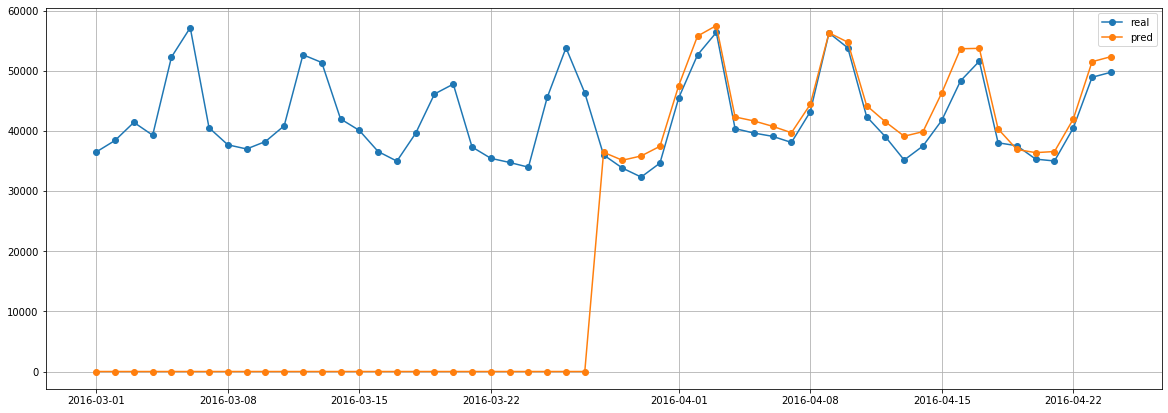

In [11]:
df = mrg_level1.query("ds >= '2016-03-01'")

plt.figure(figsize=(20,7))
plt.plot_date(df.ds, df.y, "o-", label="real")
plt.plot_date(df.ds, df.y_pred, "o-", label="pred")
plt.grid()
plt.legend(loc="best")
plt.show()

In [12]:
predict_data = make_time_range(valid_start, valid_end, "D")

In [13]:
df = pd.concat([
    mrg_level1.query("ds < @valid_start").loc[:, ["ds","y"]],
    mrg_level1.query("ds >= @valid_start").loc[:, ["ds","y_pred"]].rename({"y_pred":"y"}, axis=1)],
    ignore_index=True)

trend_model1 = TrendEstimator(primary_bandwidths=np.arange(20, 45), middle_bandwidth=35, final_bandwidth=39, alpha=5)
trend_model1.fit(df)
trend1 = trend_model1.predict(predict_data)

In [14]:
df = mrg_level1.query("ds < @valid_start").loc[:, ["ds","y"]]

trend_model2 = TrendEstimator(primary_bandwidths=np.arange(76, 78), middle_bandwidth=48, final_bandwidth=70, alpha=6)
trend_model2.fit(df)
trend2 = trend_model2.predict(predict_data)

In [15]:
_mrg_level1 = (mrg_level1
              .merge(trend1, on="ds")
              .merge(trend2, on="ds")
             )
_mrg_level1

,ds,y,y_pred,trend_x,trend_y
0,2016-03-28,36041.0,36478.057414,43197.949200,42353.437503
1,2016-03-29,33857.0,35154.896566,43276.396107,42375.232705
2,2016-03-30,32359.0,35868.767157,43377.624988,42397.027907
3,2016-03-31,34681.0,37476.922557,43479.440845,42418.823109
4,2016-04-01,45536.0,47582.182248,43574.606482,42440.618312
5,2016-04-02,52672.0,55815.573252,43651.825734,42462.413514
6,2016-04-03,56425.0,57567.245736,43702.398029,42484.208716
7,2016-04-04,40418.0,42359.703829,43730.362216,42506.003918
8,2016-04-05,39683.0,41697.486732,43750.515943,42527.799120
9,2016-04-06,39134.0,40803.100613,43808.810285,42549.594323


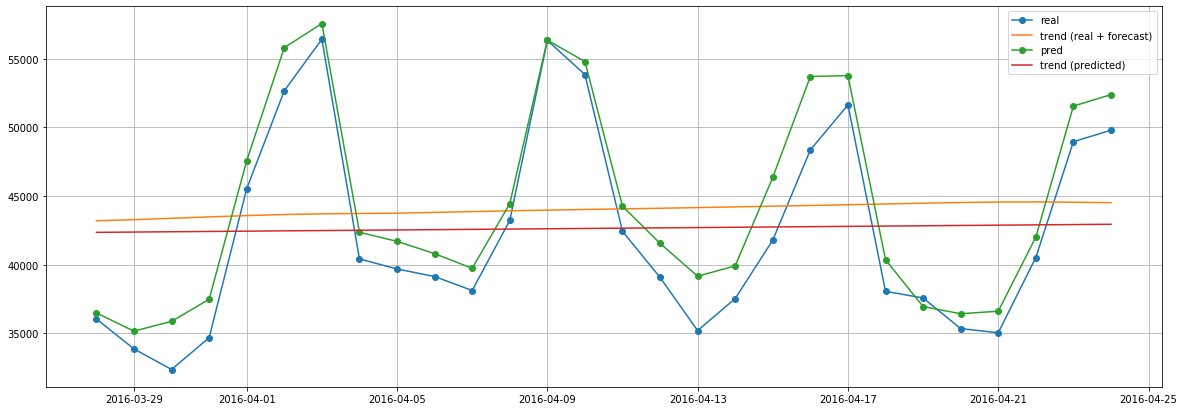

In [16]:
df = _mrg_level1.query("ds >= '2016-03-25'")

plt.figure(figsize=(20,7))
plt.plot_date(df.ds, df.y, "o-", label="real")
plt.plot_date(df.ds, df.trend_x, "-", label="trend (real + forecast)")
plt.plot_date(df.ds, df.y_pred, "o-", label="pred")
plt.plot_date(df.ds, df.trend_y, "-", label="trend (predicted)")
plt.grid()
plt.legend(loc="best")
plt.show()

***
## Level 3

In [17]:
mrg_level3 = mrg.groupby(["ds","store_id"])[["y","y_pred"]].sum().reset_index()

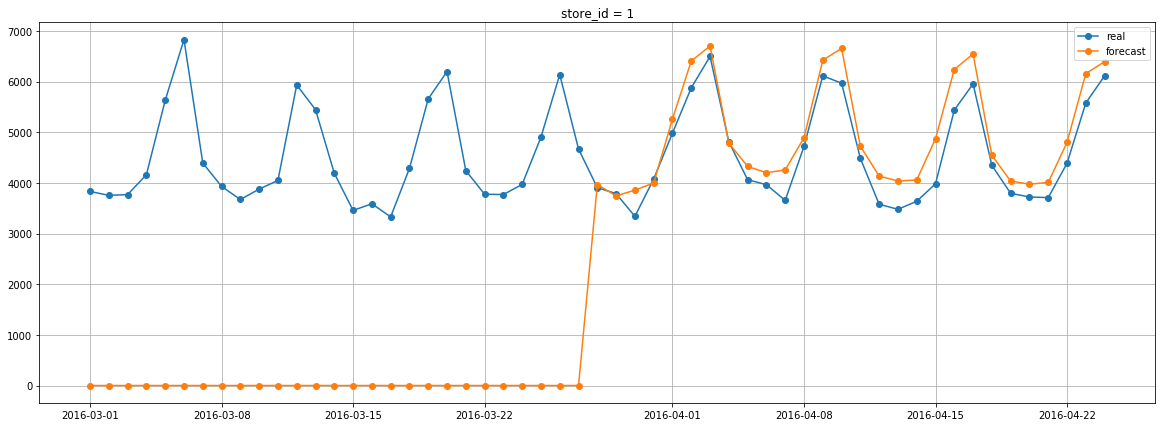

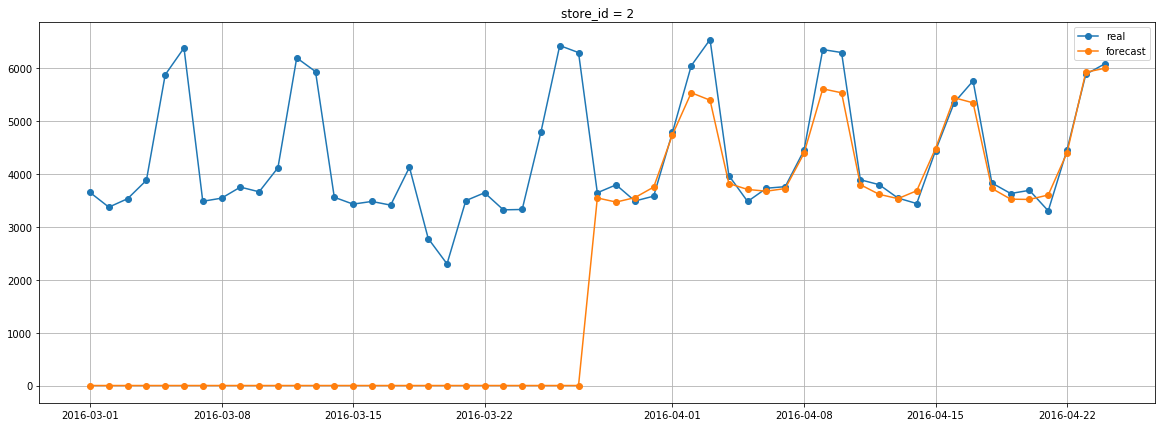

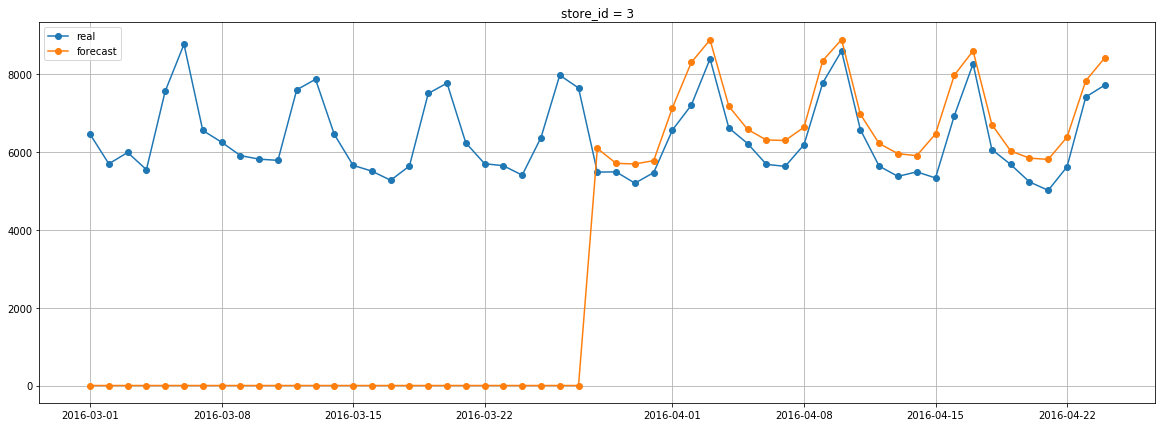

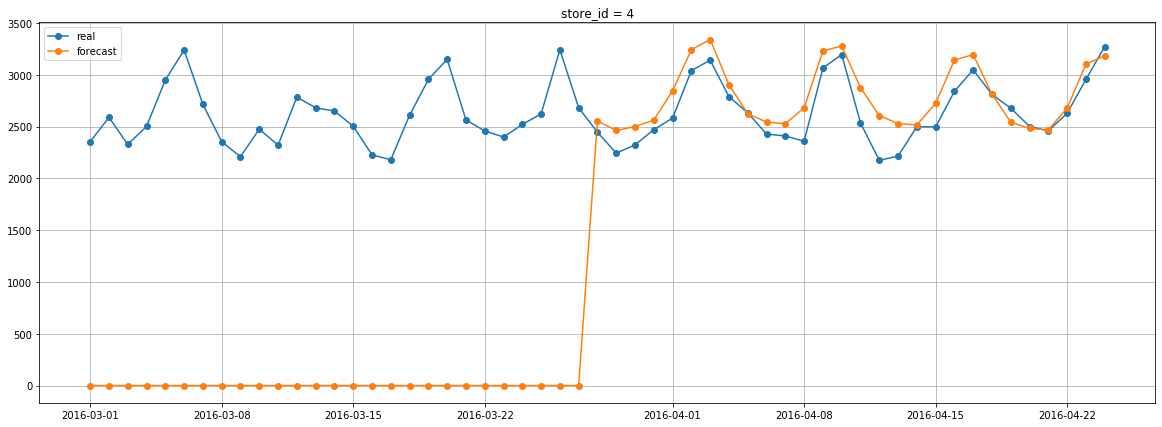

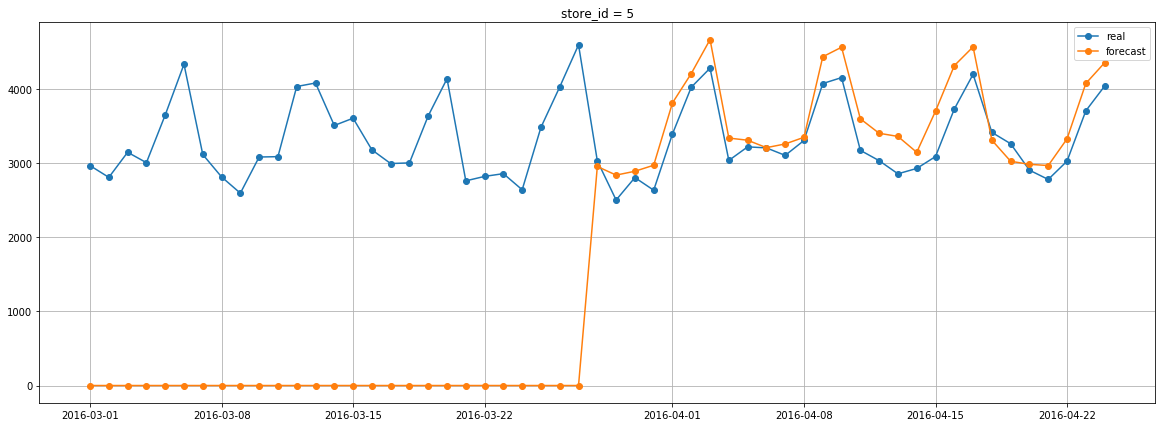

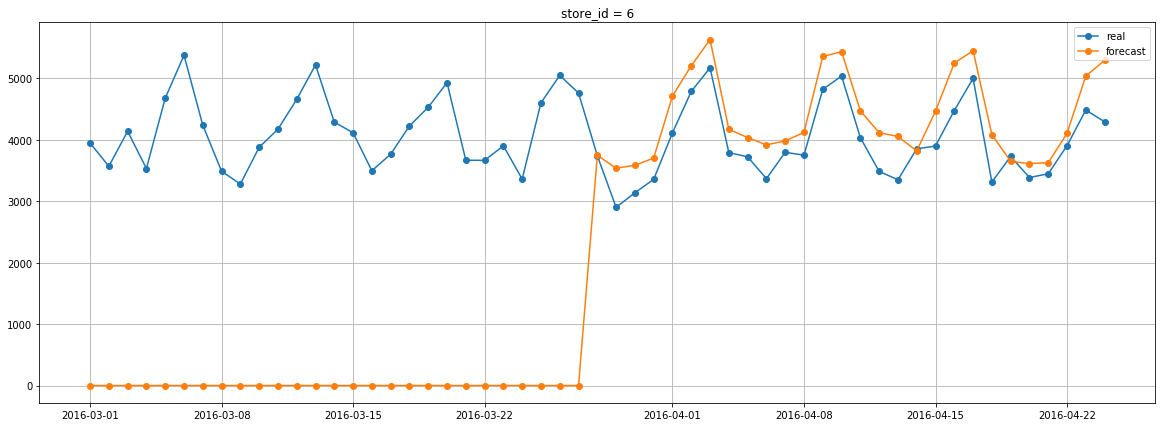

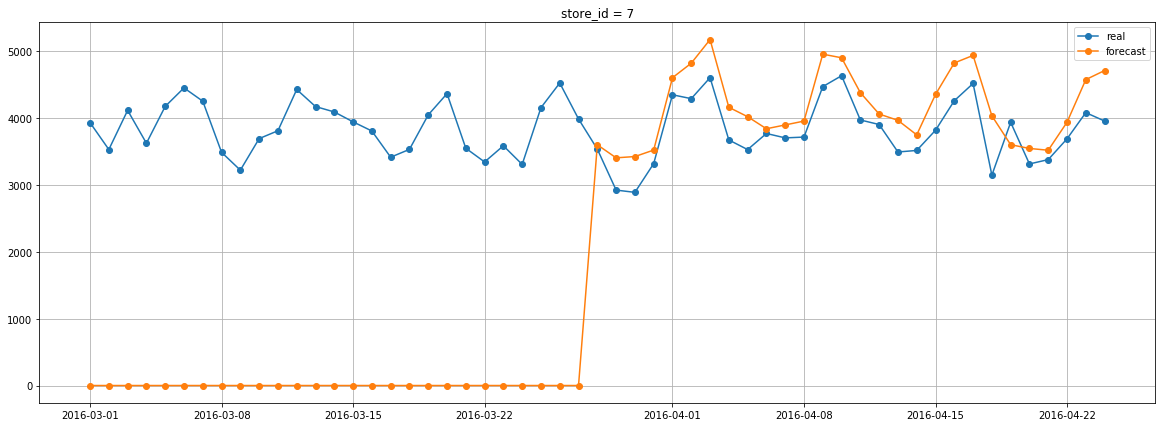

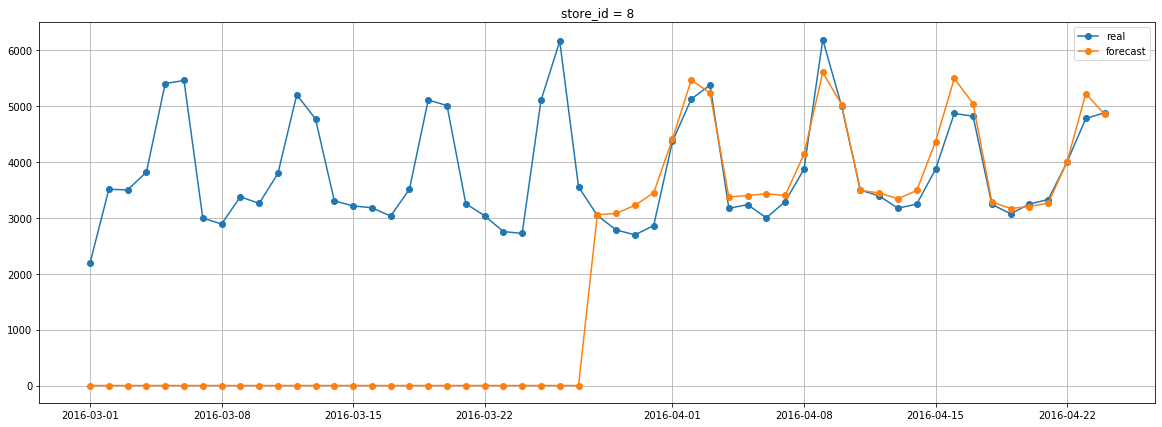

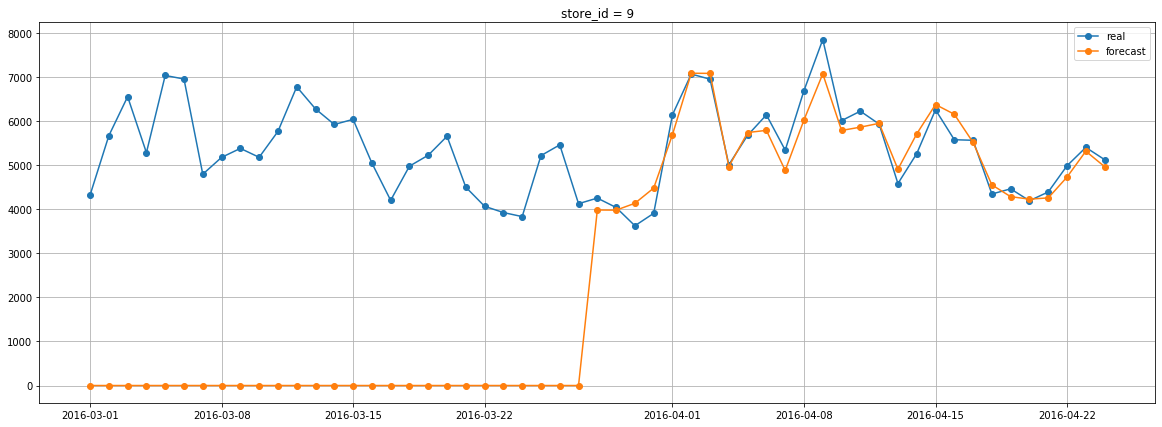

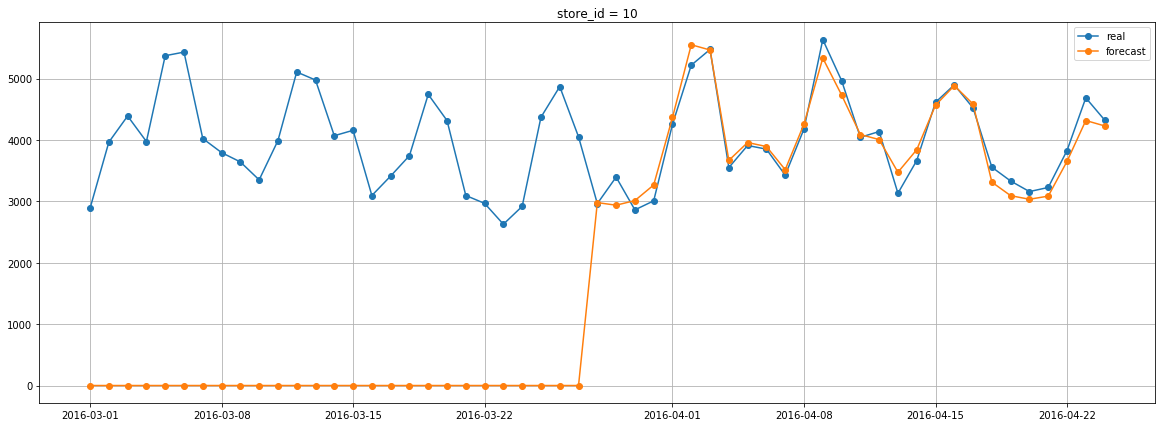

In [18]:
for store_id in mrg_level3.store_id.unique():
    df = mrg_level3.query("store_id == @store_id & ds >= '2016-03-01'")

    plt.figure(figsize=(20,7))
    plt.title(f"store_id = {store_id}")
    plt.plot_date(df.ds, df.y, "o-", label="real")
    plt.plot_date(df.ds, df.y_pred, "o-", label="forecast")
    plt.grid()
    plt.legend(loc="best")
    plt.show()

In [19]:
kwargs1 = {
    "primary_bandwidths": np.arange(40, 47),
    "middle_bandwidth": 34,
    "final_bandwidth": 15,
    "alpha": 5,
}

kwargs2 = {
    "primary_bandwidths":np.arange(109, 119),
    "middle_bandwidth": 37, 
    "final_bandwidth": 31, 
    "alpha": 10, 
}

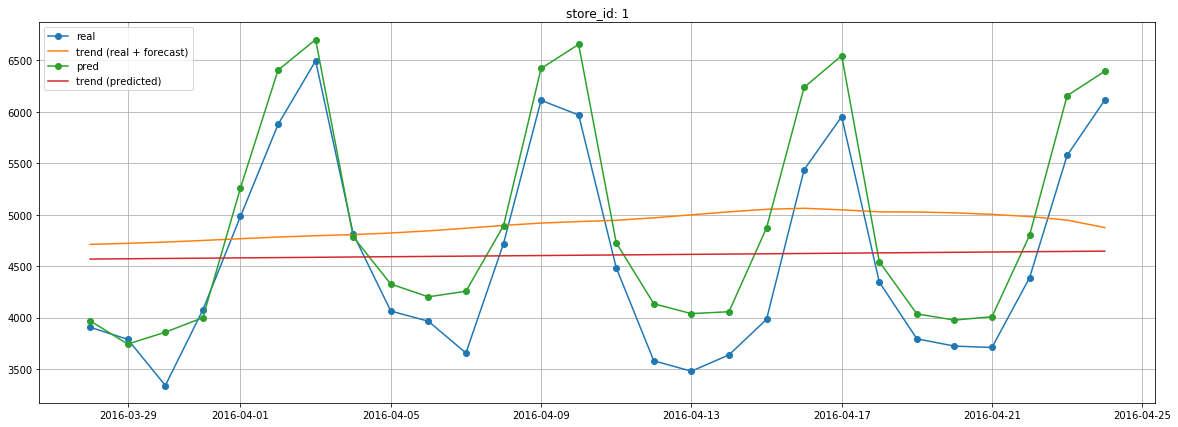

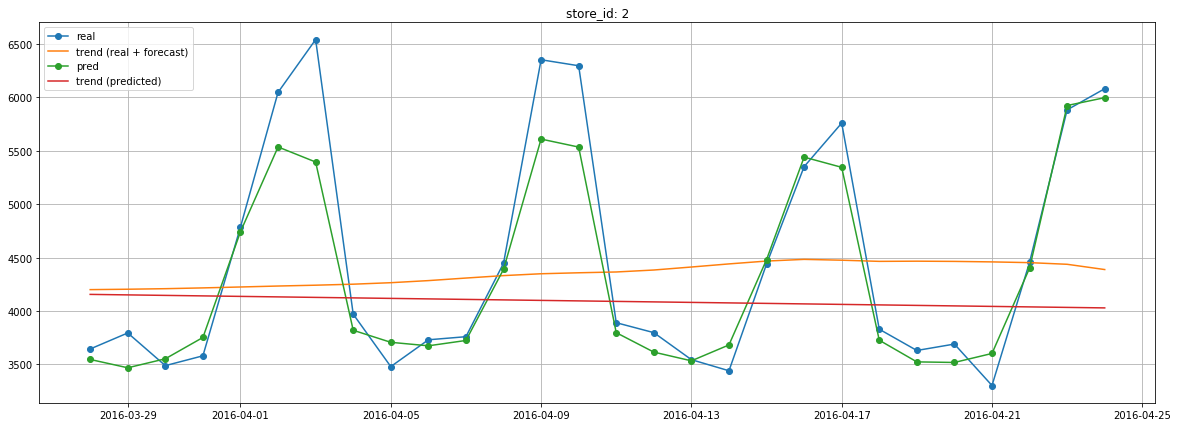

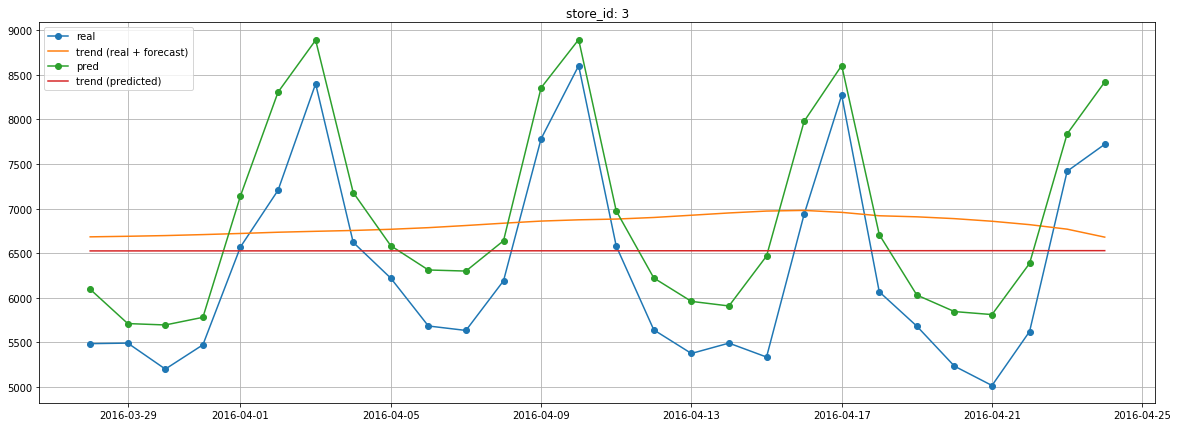

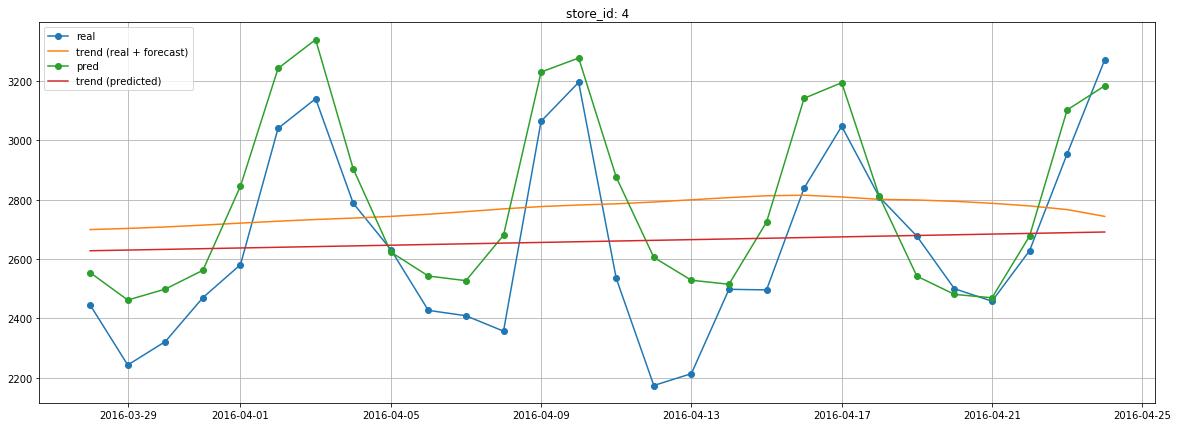

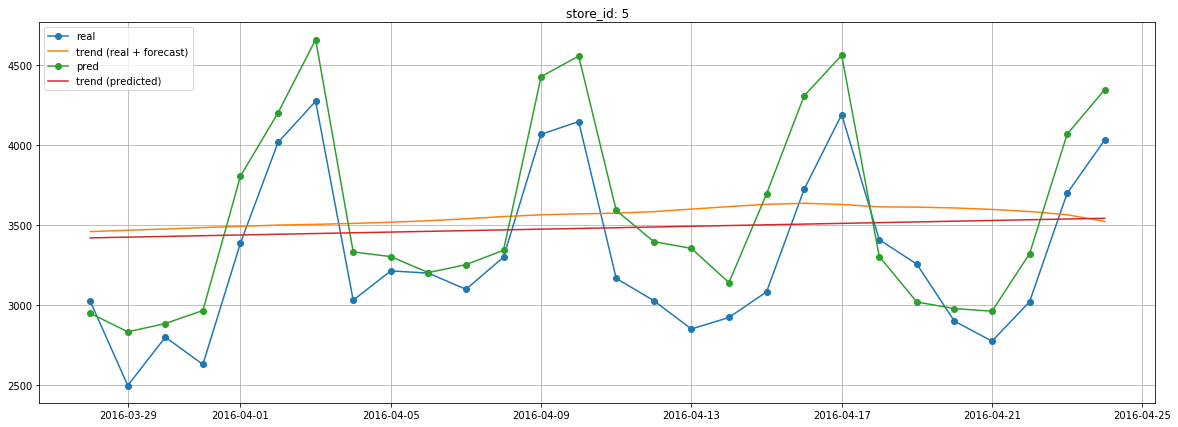

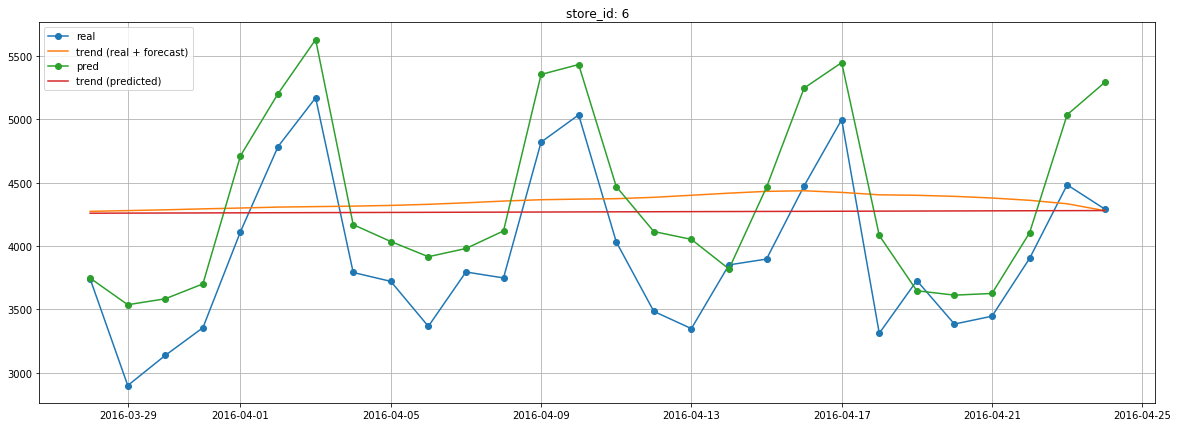

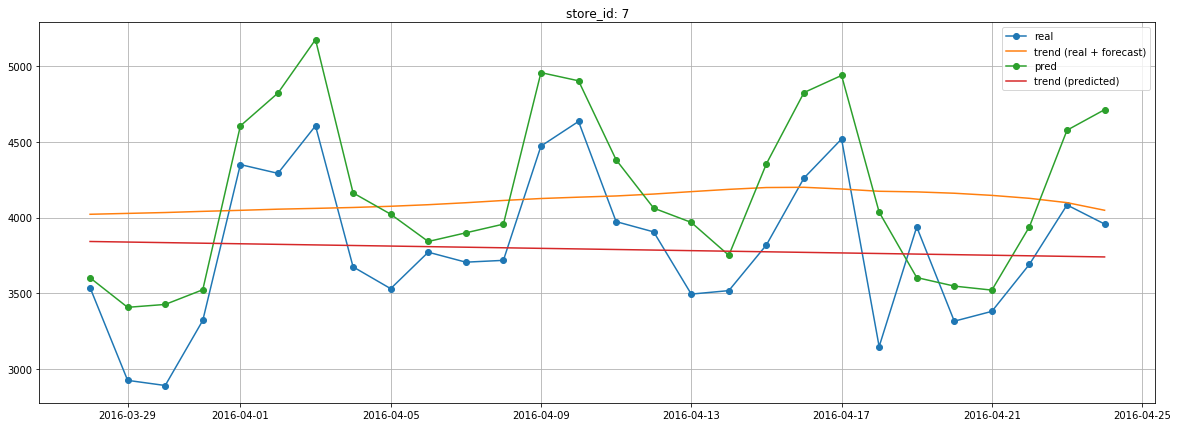

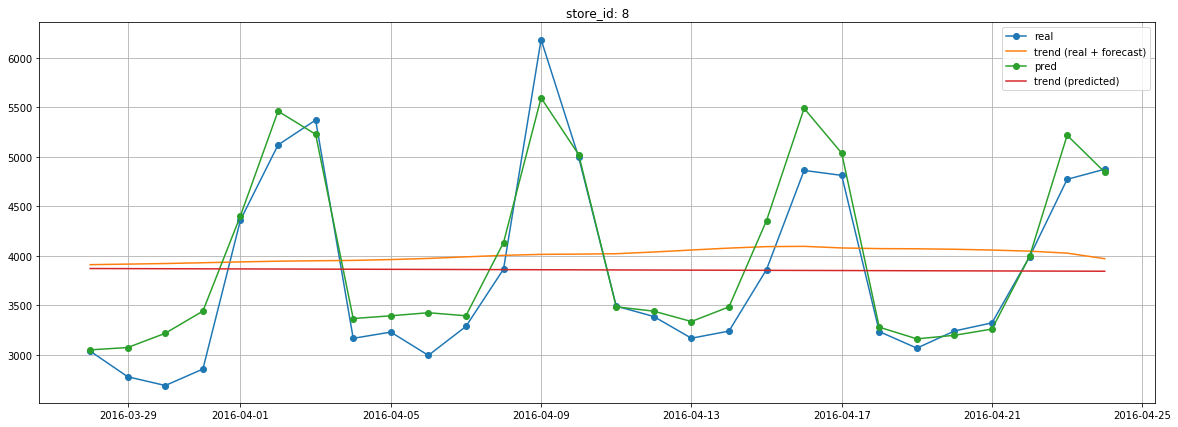

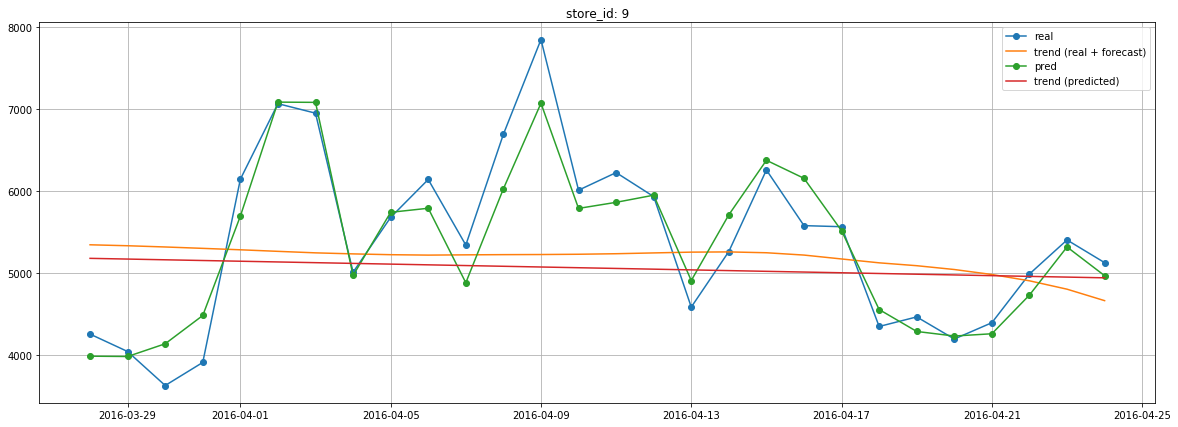

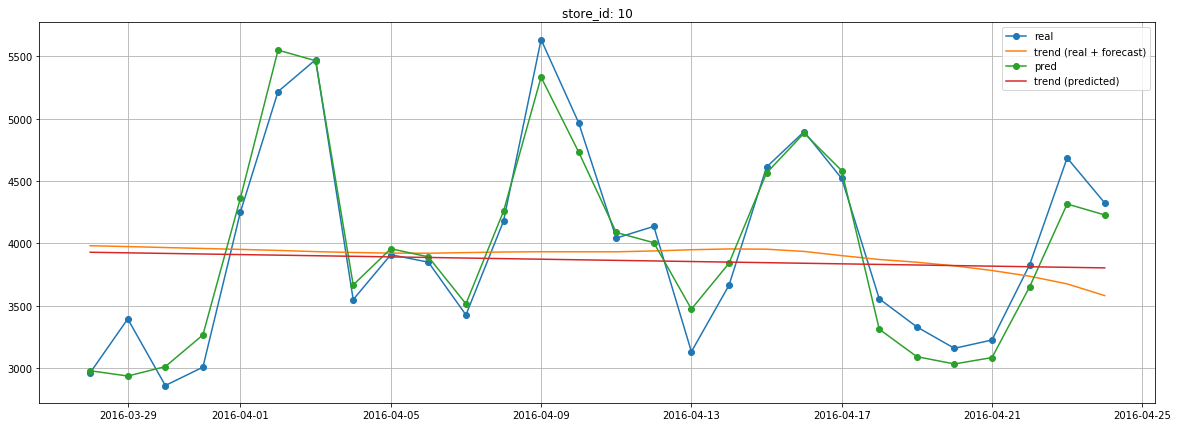

In [20]:
for store_id in mrg_level3.store_id.unique():
    df = pd.concat([
        mrg_level3.query("store_id == @store_id & ds < @valid_start").loc[:, ["ds","y"]],
        mrg_level3.query("store_id == @store_id & ds >= @valid_start").loc[:, ["ds","y_pred"]].rename({"y_pred":"y"}, axis=1)],
        ignore_index=True)

    trend_model1 = TrendEstimator(**kwargs1)
    trend_model1.fit(df)
    trend1 = trend_model1.predict(predict_data)
    
    df = mrg_level3.query("store_id == @store_id & ds < @valid_start").loc[:, ["ds","y"]]

    trend_model2 = TrendEstimator(**kwargs2)
    trend_model2.fit(df)
    trend2 = trend_model2.predict(predict_data)
    
    _mrg_level3 = (mrg_level3.query("store_id == @store_id")
                  .merge(trend1, on="ds")
                  .merge(trend2, on="ds")
                 )
    
    df = _mrg_level3.query("ds >= '2016-03-20'")
    plt.figure(figsize=(20,7))
    plt.title(f"store_id: {store_id}")
    plt.plot_date(df.ds, df.y, "o-", label="real")
    plt.plot_date(df.ds, df.trend_x, "-", label="trend (real + forecast)")
    plt.plot_date(df.ds, df.y_pred, "o-", label="pred")
    plt.plot_date(df.ds, df.trend_y, "-", label="trend (predicted)")
    plt.grid()
    plt.legend(loc="best")
    plt.show()
    

***
## trend corrections

In [21]:
ts_id_columns_by_level = {
    1: [],
    2: ["state_id"],
    3: ["store_id"],
    4: ["cat_id"],
    5: ["dept_id"],
    6: ["state_id", "cat_id"],
    7: ["state_id", "dept_id"],
    8: ["store_id", "cat_id"],
    9: ["store_id", "dept_id"],
    10: ["item_id"],
    11: ["item_id", "state_id"],
    12: ["item_id", "store_id"]
}

def apply_trend_correction(data, forecast, level, kwargs1, kwargs2):
    ts_uid_columns = ts_id_columns_by_level[level]
    start_date = forecast.ds.min()
    end_date = forecast.ds.max()
    predict_data = make_time_range(start_date, end_date, "D")
    
    mrg = pd.merge(data.query("ds <= @end_date").loc[:, ["ds","item_id","dept_id","cat_id","store_id","state_id","y"]],
                   forecast,
                   how="left", on=["ds","item_id","store_id"])
    mrg_agg = mrg.groupby(["ds"]+ts_uid_columns)[["y","y_pred"]].sum().reset_index()
    
    ts_uid_values = mrg_agg.loc[:, ts_uid_columns].drop_duplicates()
    corrected_dataframes = list()
    
    for _,row in ts_uid_values.iterrows():
        query_string = " & ".join([f"{col} == {value}" for col,value in row.iteritems()])

        df = pd.concat([
            mrg_agg.query(query_string + "& ds < @start_date").loc[:, ["ds","y"]],
            mrg_agg.query(query_string + "& ds >= @start_date").loc[:, ["ds","y_pred"]].rename({"y_pred":"y"}, axis=1)],
            ignore_index=True)

        trend_model1 = TrendEstimator(**kwargs1)
        trend_model1.fit(df)
        trend1 = trend_model1.predict(predict_data)

        trend_model2 = TrendEstimator(**kwargs2)
        trend_model2.fit(df.query("ds < @start_date"))
        trend2 = trend_model2.predict(predict_data)

        _df = (mrg_agg.query(query_string)
               .merge(trend1, on="ds", how="inner")
               .merge(trend2, on="ds", how="inner"))
        _df["y_pred"] -= _df.eval("trend_x - trend_y")
        corrected_dataframes.append(_df.loc[:, ["ds","store_id","y_pred"]])
        
    return pd.concat(corrected_dataframes, ignore_index=True)

def trimean(array, axis=0):
    quantiles = np.percentile(array, [25, 50, 75], axis=axis)
    return (quantiles[0,:] + 2*quantiles[1,:] + quantiles[2,:])/4

def apply_robust_trend_correction(data, forecast, level, kwargs_list):
    ts_uid_columns = ts_id_columns_by_level[level]
    start_date = forecast.ds.min()
    end_date = forecast.ds.max()
    predict_data = make_time_range(start_date, end_date, "D")
    
    mrg = pd.merge(data.query("ds <= @end_date").loc[:, ["ds","item_id","dept_id","cat_id","store_id","state_id","y"]],
                   forecast,
                   how="left", on=["ds","item_id","store_id"])
    mrg_agg = mrg.groupby(["ds"]+ts_uid_columns)[["y","y_pred"]].sum().reset_index()
    
    ts_uid_values = mrg_agg.loc[:, ts_uid_columns].drop_duplicates()
    corrected_dataframes = list()
    
    for _,row in ts_uid_values.iterrows():
        query_string = " & ".join([f"{col} == {value}" for col,value in row.iteritems()])

        df = pd.concat([
            mrg_agg.query(query_string + "& ds < @start_date").loc[:, ["ds","y"]],
            mrg_agg.query(query_string + "& ds >= @start_date").loc[:, ["ds","y_pred"]].rename({"y_pred":"y"}, axis=1)],
            ignore_index=True)

        all_corrections = list()
        for kwargs1,kwargs2 in kwargs_list:
            trend_model1 = TrendEstimator(**kwargs1)
            trend_model1.fit(df)
            trend1 = trend_model1.predict(predict_data)

            trend_model2 = TrendEstimator(**kwargs2)
            trend_model2.fit(df.query("ds < @start_date"))
            trend2 = trend_model2.predict(predict_data)

            all_corrections.append(trend1.trend.values - trend2.trend.values)

        trend_correction = trimean(all_corrections, axis=0)
        _df = mrg_agg.query(query_string + "& @start_date <= ds <= @end_date").copy()
        _df["y_pred"] -= trend_correction
        corrected_dataframes.append(_df.loc[:, ["ds","store_id","y_pred"]])
        
    return pd.concat(corrected_dataframes, ignore_index=True)

In [22]:
kwargs1 = {
    "primary_bandwidths": np.arange(40, 47),
    "middle_bandwidth": 34,
    "final_bandwidth": 15,
    "alpha": 5,
}

kwargs2 = {
    "primary_bandwidths":np.arange(109, 119),
    "middle_bandwidth": 37, 
    "final_bandwidth": 31, 
    "alpha": 10, 
}

In [23]:
kwargs_list = [
    ({"primary_bandwidths": np.arange(41, 47),
     "middle_bandwidth": 33,
     "final_bandwidth": 15,
     "alpha": 4,
      "drop_last_n": 0},
     {"primary_bandwidths": np.arange(112, 119),
     "middle_bandwidth": 38,
     "final_bandwidth": 33,
     "alpha": 2}),
    
    ({"primary_bandwidths": np.arange(20, 55),
     "middle_bandwidth": 55,
     "final_bandwidth": 38,
     "alpha": 0,
      "drop_last_n": 1},
     {"primary_bandwidths": np.arange(112, 119),
     "middle_bandwidth": 43,
     "final_bandwidth": 33,
     "alpha": 0}),
        
    ({"primary_bandwidths": np.arange(23, 48),
     "middle_bandwidth": 46,
     "final_bandwidth": 14,
     "alpha": 8,
      "drop_last_n": 1},
     {"primary_bandwidths": np.arange(103, 119),
     "middle_bandwidth": 52,
     "final_bandwidth": 31,
     "alpha": 10}),

    ({"primary_bandwidths": np.arange(16, 30),
     "middle_bandwidth": 39,
     "final_bandwidth": 29,
     "alpha": 5,
      "drop_last_n": 1},
     {"primary_bandwidths": np.arange(107, 116),
     "middle_bandwidth": 156,
     "final_bandwidth": 36,
     "alpha": 0}),
    
]

In [24]:
%%time
#forecast_level3 = apply_trend_correction(data, forecast, level=3, kwargs1=kwargs1, kwargs2=kwargs2)
forecast_level3 = apply_robust_trend_correction(data, forecast, level=3, kwargs_list=kwargs_list)
forecast_level3["store_id"] = encoders["store"].inverse_transform(forecast_level3.store_id)

CPU times: user 20.6 s, sys: 14 s, total: 34.6 s
Wall time: 37.8 s


In [25]:
forecast_level1 = forecast_level3.groupby("ds")["y_pred"].sum().reset_index().set_index("ds").rename({"y_pred":"root"}, axis=1)

In [26]:
forecast_level3 = forecast_level3.pivot(index="ds", columns="store_id", values="y_pred")

In [27]:
forecast = forecast.merge(hierarchy.loc[:, ["id","item_id","store_id"]], how="left")
forecast_level12 = forecast.pivot(index="ds", columns="id", values="y_pred")

In [28]:
forecast_concat = pd.concat([forecast_level1, forecast_level3, forecast_level12], axis=1)
forecast_concat.head()

,root,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,...,HOUSEHOLD_2_516_CA_1,HOUSEHOLD_2_516_CA_2,HOUSEHOLD_2_516_CA_3,HOUSEHOLD_2_516_CA_4,HOUSEHOLD_2_516_TX_1,HOUSEHOLD_2_516_TX_2,HOUSEHOLD_2_516_TX_3,HOUSEHOLD_2_516_WI_1,HOUSEHOLD_2_516_WI_2,HOUSEHOLD_2_516_WI_3
ds,,,,,,,,,,,,,,,,,,,,,
2016-03-28,35650.691348,3826.359092,3501.467274,5940.848591,2482.618423,2914.700230,3735.519914,3426.175815,3016.304319,3861.568563,...,0.177135,0.161131,0.149384,0.094757,0.118252,0.261399,0.095007,0.080105,0.047180,0.098301
2016-03-29,34267.975181,3591.941659,3413.871162,5548.010774,2387.718826,2795.475032,3521.477473,3221.028004,3033.878644,3853.537517,...,0.170662,0.157828,0.147848,0.092661,0.117455,0.267448,0.148341,0.094664,0.052988,0.101865
2016-03-30,34922.889392,3698.306101,3488.078062,5523.863943,2421.637712,2844.421197,3563.827143,3230.498414,3171.718936,4005.437765,...,0.192840,0.170677,0.156799,0.100131,0.137799,0.282393,0.164411,0.102319,0.056183,0.112027
2016-03-31,36462.140937,3827.368341,3676.391142,5598.528343,2481.286022,2922.032383,3675.683576,3316.288671,3386.788793,4349.212515,...,0.227358,0.201955,0.171076,0.108601,0.147544,0.279818,0.189258,0.117499,0.071897,0.130832
2016-04-01,46509.510276,5076.174511,4655.377592,6947.899547,2760.742820,3759.398247,4682.322258,4388.536069,4340.749884,5568.278197,...,0.241811,0.207765,0.180781,0.113424,0.144384,0.308926,0.200918,0.119135,0.077768,0.141031


In [29]:
%%time
hierarchy_dict = {"root":hierarchy_raw.store_id.unique()}

ts_id_in_forecast = forecast.id.unique()
for store_id in hierarchy_raw.store_id.unique():
    hierarchy_dict[store_id] = hierarchy_raw.query("store_id == @store_id & id in @ts_id_in_forecast").id.unique()
    
hts = HTSDistributor(hierarchy_dict)

CPU times: user 3min 40s, sys: 47 s, total: 4min 27s
Wall time: 4min 51s


In [30]:
%%time
fcst_reconc = hts.compute_forecast_proportions(forecast_concat)

CPU times: user 12.3 s, sys: 10.2 s, total: 22.5 s
Wall time: 15.9 s


In [31]:
fcst_reconc.set_index(forecast_concat.index, inplace=True)
fcst_reconc = fcst_reconc.loc[:, hts.bottom_nodes].transpose()
forecast_reconc = (
    fcst_reconc
    .reset_index()
    .rename({"index":"id"}, axis=1)
    .melt(id_vars="id", 
          value_vars=[valid_start+pd.DateOffset(days=i) for i in range(28)],
          value_name="y_pred")
              )
forecast_reconc["id"] = encoders["id"].transform(forecast_reconc.id)

***

In [33]:
# forecast proportions
_mrg = pd.merge(valid_data.loc[:, ["ds","ts_id","y"]], forecast_reconc, how="inner", left_on=["ds","ts_id"], right_on=["ds","id"])
wrmsse = evaluator.eval1._evaluate(_mrg.y_pred.values)
wrmsseL12 = evaluator.eval2._evaluate(_mrg.y_pred.values)
print("wrmsse:", wrmsse)
print("wrmsseL12:", wrmsseL12)
print(evaluator.eval1.errors_by_level)

wrmsse: 0.5013090681451635
wrmsseL12: 0.8167369893063395
{'root': 0.2415957369610277, ('state_id',): 0.312314253282234, ('store_id',): 0.44078748498481213, ('cat_id',): 0.29317359154481537, ('dept_id',): 0.38157068361665347, ('state_id', 'cat_id'): 0.38034987747609517, ('state_id', 'dept_id'): 0.4672689384268374, ('store_id', 'cat_id'): 0.5074420816351852, ('store_id', 'dept_id'): 0.5767045720148487, ('item_id',): 0.7878830091301798, ('item_id', 'state_id'): 0.8098815993629338, ('item_id', 'store_id'): 0.8167369893063395}


In [128]:
# lsmr + weights
_mrg = pd.merge(valid_data.loc[:, ["ds","ts_id","y"]], forecast_reconc, how="inner", left_on=["ds","ts_id"], right_on=["ds","id"])
wrmsse = evaluator.eval1._evaluate(_mrg.y_pred.values)
wrmsseL12 = evaluator.eval2._evaluate(_mrg.y_pred.values)
print("wrmsse:", wrmsse)
print("wrmsseL12:", wrmsseL12)
print(evaluator.eval1.errors_by_level)

wrmsse: 0.5048728126795009
wrmsseL12: 0.8257652238301539
{'root': 0.22312135303249953, ('state_id',): 0.3039193361381256, ('store_id',): 0.43533810527295536, ('cat_id',): 0.27274506804965853, ('dept_id',): 0.39135484978435064, ('state_id', 'cat_id'): 0.3666915843962467, ('state_id', 'dept_id'): 0.48138834430597466, ('store_id', 'cat_id'): 0.5158605213673737, ('store_id', 'dept_id'): 0.5989051650637839, ('item_id',): 0.81554089455886, ('item_id', 'state_id'): 0.8278433063540276, ('item_id', 'store_id'): 0.8257652238301539}


In [57]:
# lsmr
_mrg = pd.merge(valid_data.loc[:, ["ds","ts_id","y"]], forecast_reconc, how="inner", left_on=["ds","ts_id"], right_on=["ds","id"])
wrmsse = evaluator.eval1._evaluate(_mrg.y_pred.values)
wrmsseL12 = evaluator.eval2._evaluate(_mrg.y_pred.values)
print("wrmsse:", wrmsse)
print("wrmsseL12:", wrmsseL12)
print(evaluator.eval1.errors_by_level)

wrmsse: 0.5156771953348134
wrmsseL12: 0.8184752330630012
{'root': 0.22312277907514652, ('state_id',): 0.3039209313049871, ('store_id',): 0.435339125647412, ('cat_id',): 0.32898437187807383, ('dept_id',): 0.4294643536797471, ('state_id', 'cat_id'): 0.4061819279232032, ('state_id', 'dept_id'): 0.5026270072196125, ('store_id', 'cat_id'): 0.5304241799089403, ('store_id', 'dept_id'): 0.6023769959330352, ('item_id',): 0.7939035852759599, ('item_id', 'state_id'): 0.8133058531086415, ('item_id', 'store_id'): 0.8184752330630012}


***